## Main Task
Building a Game Recommendation System with Steam Platform Data!

### Data Understanding
The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content.  
Additionally, it contains detailed information about games and add-ons.  

The dataset consists of three main entities:

1. **games.csv** - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;
2. **users.csv** - a table of user profiles' public information: the number of purchased products and reviews published;
3. **recommendations.csv** - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.

The dataset does not contain any personal information about users on a Steam Platform. A preprocessing pipeline anonymized all user IDs. All collected data is accessible to a member of the general public.

Link to the dataset: [https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/data]

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
games_df = pd.read_csv('datasets/games.csv')
users_df = pd.read_csv('datasets/users.csv')
recommendations_df = pd.read_csv('datasets/recommendations.csv')

In [3]:
games_df.head(2)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True


In [4]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB


In [5]:
users_df.head(2)

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1


In [6]:
recommendations_df.head(2)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1


### Data PreProcessing

In [7]:
games_df.isnull().sum()

app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

In [8]:
users_df.isnull().sum()

user_id     0
products    0
reviews     0
dtype: int64

In [9]:
recommendations_df.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64

### EDA on Games Dataset
#### What is the distribution of game ratings?

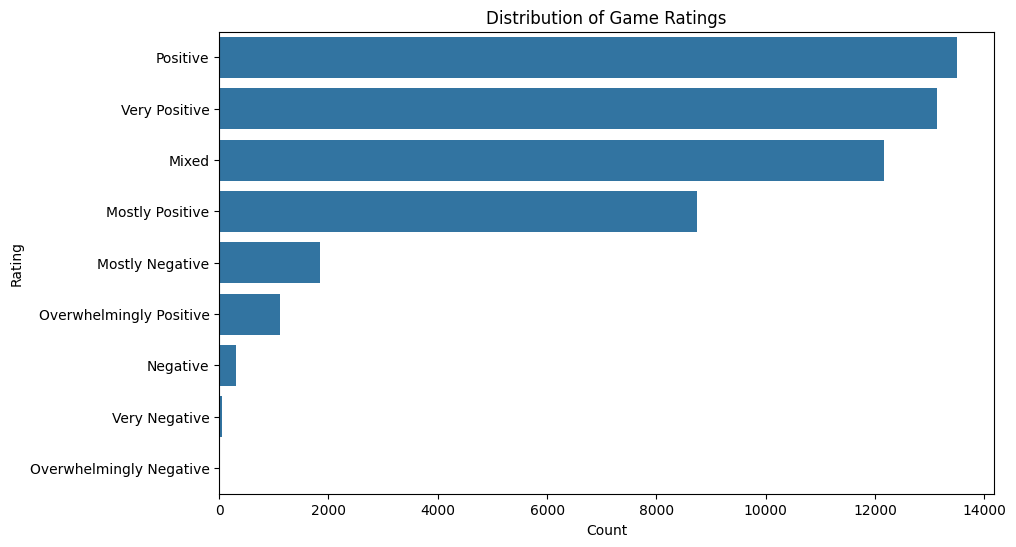

In [10]:
# Count plot for game ratings
plt.figure(figsize=(10, 6))
sns.countplot(y=games_df['rating'], order=games_df['rating'].value_counts().index)
plt.title('Distribution of Game Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

> 'Posivie', 'Very Positive', 'Mixed' and 'Mostly Positive' are the top 3 Ratings groups! The distribution becomes very low for 'Mostly Negative', 'Overwhelmingly Positive', 'Negative', 'Very Negative'! The 'Overwhelmingly Negative' is zero.

#### What is the distribution of Final Price of games?

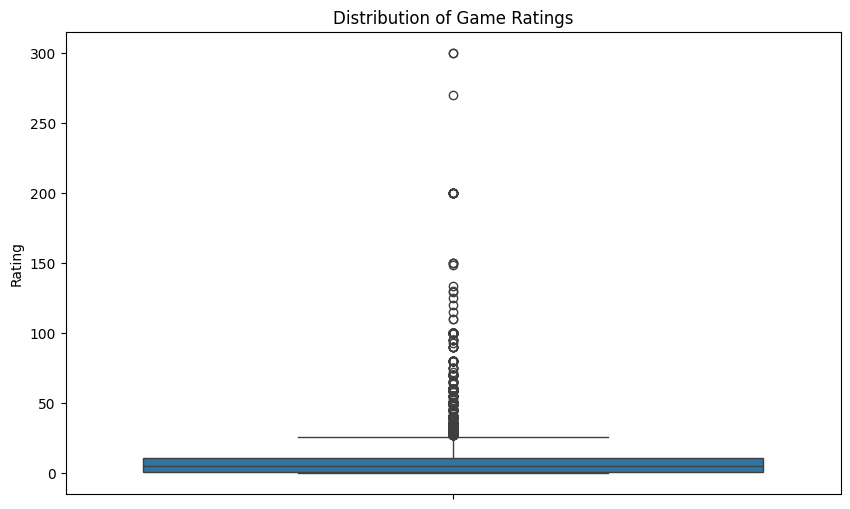

In [11]:
# Boxplot for game ratings
plt.figure(figsize=(10, 6))
sns.boxplot(y=games_df['price_final'])
plt.title('Distribution of Game Ratings')
plt.ylabel('Rating')
plt.show()

> The price range is between 0-12 USD, There are many outliers which means there are many games with prices around 15 to 300 USD! 
#### How do the prices (final_price) of games vary across different levels of ratings?
> Based on experience we change the range for Final_Price to 0 - 50 USD

In [12]:
# Filter out outliers in the final prices
filtered_games_df = games_df[games_df['price_final'] <= 50]

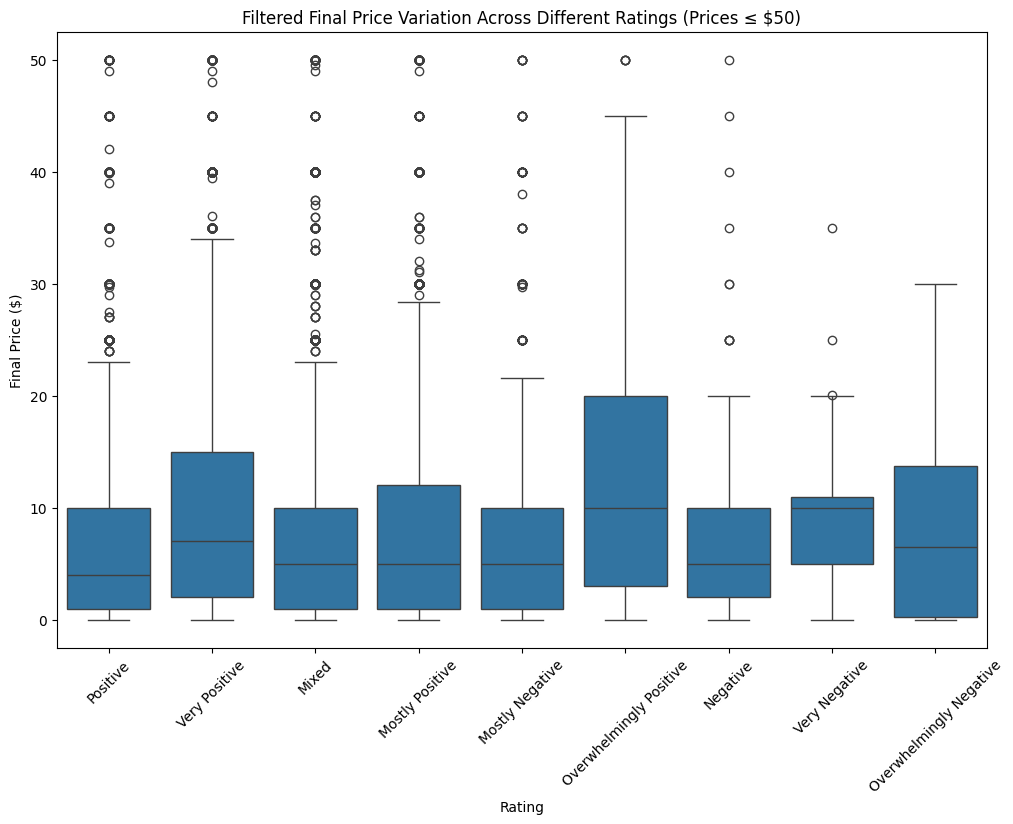

In [13]:
# Boxplot for final prices within the $0-$50 range based on ratings
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='price_final', data=filtered_games_df, order=filtered_games_df['rating'].value_counts().index)
plt.title('Filtered Final Price Variation Across Different Ratings (Prices ≤ $50)')
plt.xlabel('Rating')
plt.ylabel('Final Price ($)')
plt.xticks(rotation=45)
plt.show()

> Overwhelmingly Positive, Very Positive and Very Negative have the highest mean price between different Ratings! The other Ratings have almost the same range of price!  
The number of outliers varies between different rating groups, Mixed and Positive Ratings have the highest amount of outliers (prices over the normal range 0-12 USD)! 
#### Are there any patterns or trends in the release dates of games? 

In [14]:
# Convert 'date_release' to datetime format
games_df['date_release'] = pd.to_datetime(games_df['date_release'], errors='coerce')

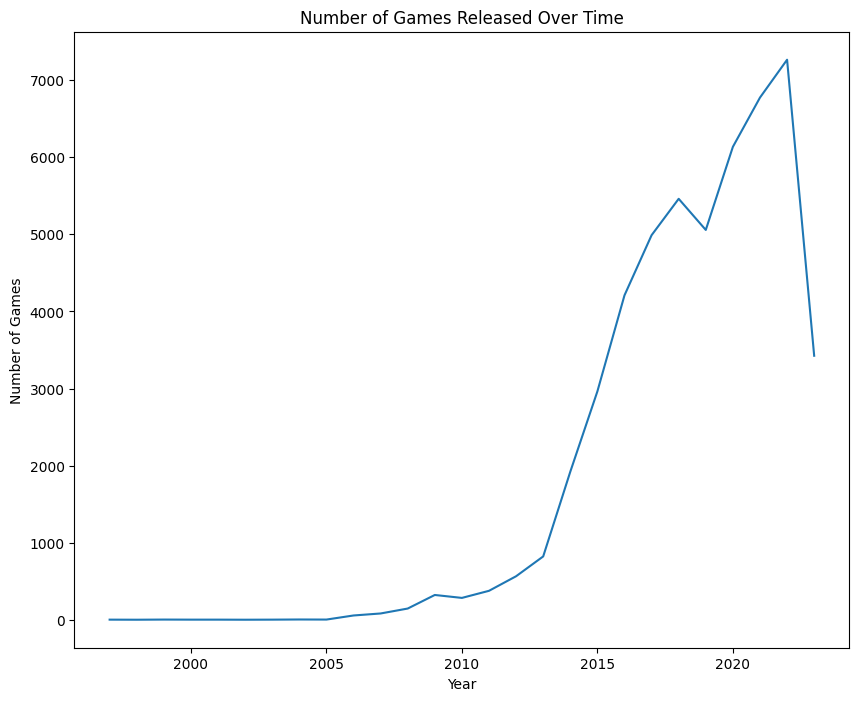

In [15]:
# Plotting the number of games released over time
plt.figure(figsize=(10, 8))
games_df['date_release'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Number of Games Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()

> There is a clear upward or positive trend in number of games released from 2000 to 2022, then it decreases! (The decrease in the plot maybe is due to not having enough data points from 2023 and later, the dataset was collected during 2023)!
#### What proportion of games are available on Windows, Mac, and Linux platforms?

In [16]:
platforms = ['win', 'mac', 'linux']
platform_counts = {platform: games_df[platform].sum() for platform in platforms}

# Total number of games
total_games = len(games_df)

# Proportion of games available on each platform
platform_proportions = {platform: count / total_games * 100 for platform, count in platform_counts.items()}

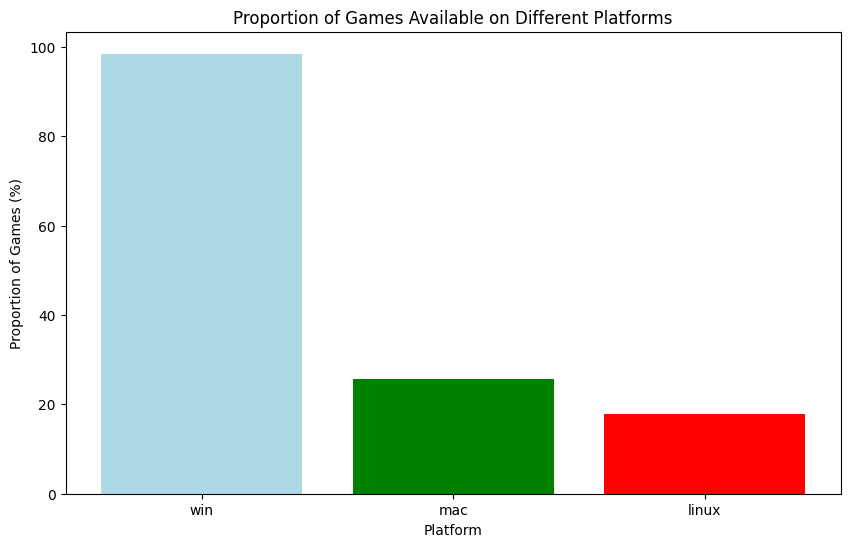

In [17]:
# Plotting the proportions
plt.figure(figsize=(10, 6))
plt.bar(platform_proportions.keys(), platform_proportions.values(), color=['lightblue', 'green', 'red'])
plt.title('Proportion of Games Available on Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Proportion of Games (%)')
plt.show()

> As expected the proportion of games for 'Windows' is much more than the proportion of games for 'Mac' and 'Linux'!
#### How does the positive_ratio correlate with the number of user_reviews?

In [18]:
# Calculate the correlation between 'positive_ratio' and 'user_reviews'
correlation_value = games_df['positive_ratio'].corr(games_df['user_reviews'])

# Print the correlation value
print(f"Correlation between Positive Ratio and Number of User Reviews: {correlation_value:.2f}")

Correlation between Positive Ratio and Number of User Reviews: 0.02


> There is very low positive correlation between 'Positive_Ratio' and 'User Reviews', Correlation here is 0.02!
#### What are the discount patterns and how do they relate to the game's rating?

In [23]:
# Categorize the 'discount' feature into bins
discount_bins = [0, 5, 10, 20, 30, 50, 100]
discount_labels = ['0', '<5', '5-10', '10-20', '20-30', '>= 30']
games_df['discount_category'] = pd.cut(games_df['discount'], bins=discount_bins, labels=discount_labels, include_lowest=True)

In [30]:
# Group by 'rating' and 'discount_category' to analyze patterns
discount_rating_group = games_df.groupby(['rating', 'discount_category'], observed=False).size().unstack().fillna(0)
print(discount_rating_group)

discount_category            0  <5  5-10  10-20  20-30  >= 30
rating                                                       
Mixed                    11076  21    54     63    249    694
Mostly Negative           1723   0    11      3     31     81
Mostly Positive           7791  28    58     82    242    537
Negative                   275   0     3      1      8     16
Overwhelmingly Negative     13   0     0      0      1      0
Overwhelmingly Positive   1033   0    12     14     13     38
Positive                 11840  86   180    172    430    794
Very Negative               58   0     0      0      2      0
Very Positive            12094  44   108    104    296    493


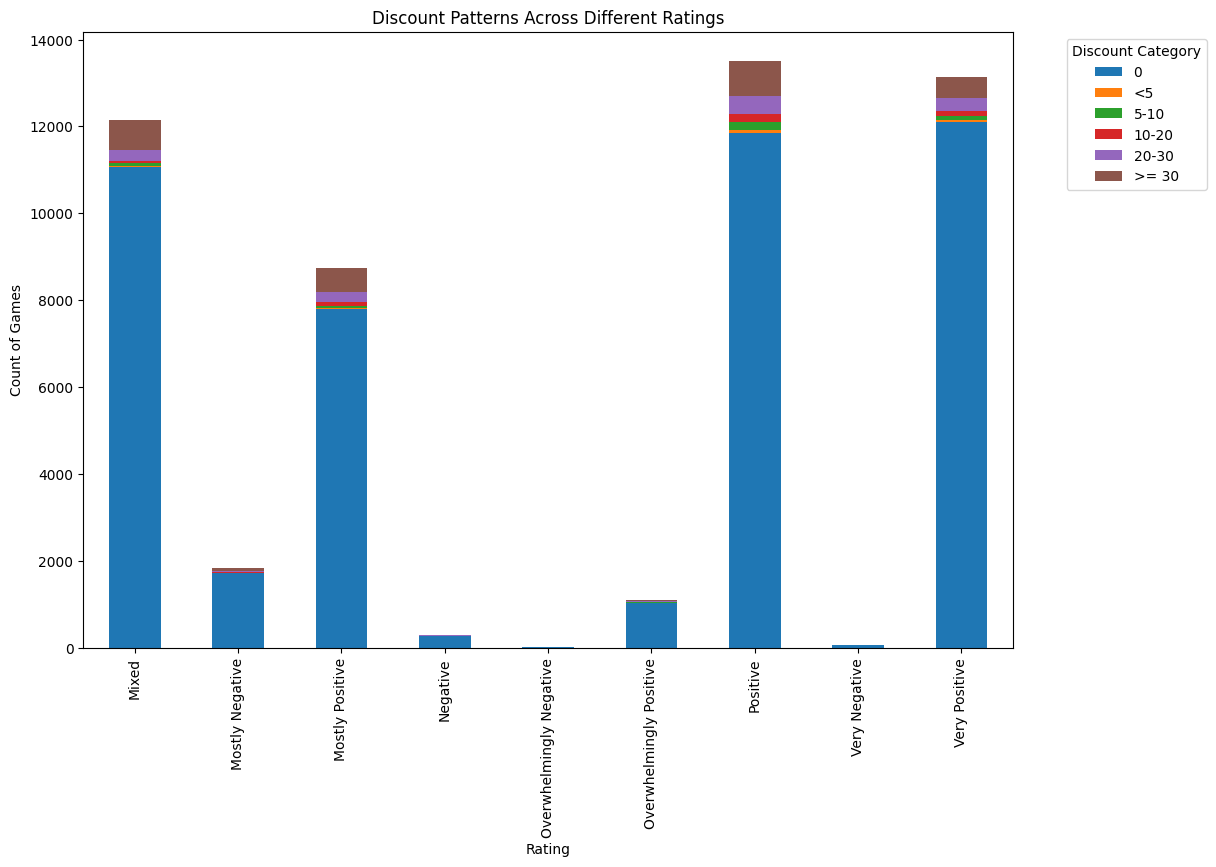

In [26]:
# Bar plot for discount patterns across different ratings
discount_rating_group.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Discount Patterns Across Different Ratings')
plt.xlabel('Rating')
plt.ylabel('Count of Games')
plt.legend(title='Discount Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> 
#### How many games are compatible with Steam Deck, and what are their ratings and prices?

#### Are there any significant outliers or anomalies in terms of pricing, ratings, release dates, or user reviews?